In [0]:
%python
from IPython.display import display, Markdown

display(Markdown("# MVP – Engenharia de Dados – Análise Econômica\n\nEste notebook apresenta o pipeline de dados construído para analisar a correlação entre IPCA, SELIC e IBOVESPA nos últimos 15 anos, com base em dados públicos simulados. O pipeline segue as etapas BRONZE → SILVER → GOLD, realiza modelagem em estrela e executa análises estatísticas."))


# MVP – Engenharia de Dados – Análise Econômica

Este notebook apresenta o pipeline de dados construído para analisar a correlação entre IPCA, SELIC e IBOVESPA nos últimos 15 anos, com base em dados públicos simulados. O pipeline segue as etapas BRONZE → SILVER → GOLD, realiza modelagem em estrela e executa análises estatísticas.

In [0]:
%python
# Configuração Inicial: Criar e usar o banco de dados para o projeto
spark.sql("CREATE DATABASE IF NOT EXISTS mvp_economia")
spark.sql("USE mvp_economia")


Out[2]: DataFrame[]

In [0]:
%python
from IPython.display import display, Markdown

display(Markdown("## Leitura dos Dados BRONZE\n\nNesta etapa, realizamos a leitura dos arquivos CSV que contêm os dados brutos de IPCA, SELIC e IBOVESPA."))


## Leitura dos Dados BRONZE

Nesta etapa, realizamos a leitura dos arquivos CSV que contêm os dados brutos de IPCA, SELIC e IBOVESPA.

In [0]:
%python
path_ipca = "/FileStore/tables/ipca.csv"
path_selic = "/FileStore/tables/selic.csv"
path_ibov = "/FileStore/tables/ibov.csv"

df_ipca_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_ipca)
df_selic_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_selic)
df_ibov_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_ibov)


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-3105057663854746>:5
      2 path_selic = "/FileStore/tables/selic.csv"
      3 path_ibov = "/FileStore/tables/ibov.csv"
----> 5 df_ipca_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_ipca)
      6 df_selic_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_selic)
      7 df_ibov_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_ibov)

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/py

In [0]:
%python
display(dbutils.fs.ls("/FileStore/"))


[FileInfo(path='dbfs:/FileStore/economia_correlacao.csv', name='economia_correlacao.csv', size=5271, modificationTime=1743530389000),
 FileInfo(path='dbfs:/FileStore/gold_economia.csv', name='gold_economia.csv', size=5271, modificationTime=1743650682000),
 FileInfo(path='dbfs:/FileStore/shared_uploads/', name='shared_uploads/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/', name='tables/', size=0, modificationTime=0)]

In [0]:
%python
# Lendo o arquivo combinado BRONZE
path_economia = "/FileStore/economia_correlacao.csv"

df_economia_bronze = spark.read.option("header", True).option("inferSchema", True).csv(path_economia)

# Mostrar os dados lidos
display(df_economia_bronze)


DataFrame[data: date, ipca: double, selic: double, ibov: int]

In [0]:
%python
from IPython.display import display, Markdown

display(Markdown("## Transformação SILVER\n\nNesta etapa, realizamos a limpeza e padronização dos dados brutos, garantindo qualidade e consistência para as próximas análises."))


## Transformação SILVER

Nesta etapa, realizamos a limpeza e padronização dos dados brutos, garantindo qualidade e consistência para as próximas análises.

In [0]:
%python
# Removendo registros nulos
df_economia_silver = df_economia_bronze.dropna()

# Conferindo o resultado
display(df_economia_silver)


DataFrame[data: date, ipca: double, selic: double, ibov: int]

In [0]:
%python
# Salvando o dado como tabela GOLD
df_economia_silver.write.format("delta").mode("overwrite").saveAsTable("gold_economia")


In [0]:
%python
display(Markdown("## Modelagem em Estrela\n\nNesta etapa, criamos uma tabela fato principal e tabelas de dimensão para os indicadores econômicos, utilizando a camada GOLD como fonte de dados."))


## Modelagem em Estrela

Nesta etapa, criamos uma tabela fato principal e tabelas de dimensão para os indicadores econômicos, utilizando a camada GOLD como fonte de dados.

In [0]:
%python
# Lendo a tabela GOLD
df_gold = spark.table("gold_economia")

# Criando Tabela Fato (com todas as colunas)
df_fato = df_gold.select(
    "data",
    "ipca",
    "selic",
    "ibov"
)

df_fato.write.format("delta").mode("overwrite").saveAsTable("fato_economia")

# Criando Tabela Dimensão IPCA
df_dim_ipca = df_gold.select(
    "data",
    "ipca"
)

df_dim_ipca.write.format("delta").mode("overwrite").saveAsTable("dim_ipca")

# Criando Tabela Dimensão SELIC
df_dim_selic = df_gold.select(
    "data",
    "selic"
)

df_dim_selic.write.format("delta").mode("overwrite").saveAsTable("dim_selic")

# Criando Tabela Dimensão IBOV
df_dim_ibov = df_gold.select(
    "data",
    "ibov"
)

df_dim_ibov.write.format("delta").mode("overwrite").saveAsTable("dim_ibov")


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-3105057663854753>:12
      4 # Criando Tabela Fato (com todas as colunas)
      5 df_fato = df_gold.select(
      6     "data",
      7     "ipca",
      8     "selic",
      9     "ibov"
     10 )
---> 12 df_fato.write.format("delta").mode("overwrite").saveAsTable("fato_economia")
     14 # Criando Tabela Dimensão IPCA
     15 df_dim_ipca = df_gold.select(
     16     "data",
     17     "ipca"
     18 )

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/readwrite

In [0]:
%python
spark.sql("DROP TABLE IF EXISTS fato_economia")
spark.sql("DROP TABLE IF EXISTS dim_ipca")
spark.sql("DROP TABLE IF EXISTS dim_selic")
spark.sql("DROP TABLE IF EXISTS dim_ibov")


Out[12]: DataFrame[]

In [0]:
%python
# Lendo a tabela GOLD
df_gold = spark.table("gold_economia")

# Criando Tabela Fato
df_fato = df_gold.select(
    "data",
    "ipca",
    "selic",
    "ibov"
)
df_fato.write.format("delta").mode("overwrite").saveAsTable("fato_economia")

# Criando Tabela Dimensão IPCA
df_dim_ipca = df_gold.select(
    "data",
    "ipca"
)
df_dim_ipca.write.format("delta").mode("overwrite").saveAsTable("dim_ipca")

# Criando Tabela Dimensão SELIC
df_dim_selic = df_gold.select(
    "data",
    "selic"
)
df_dim_selic.write.format("delta").mode("overwrite").saveAsTable("dim_selic")

# Criando Tabela Dimensão IBOV
df_dim_ibov = df_gold.select(
    "data",
    "ibov"
)
df_dim_ibov.write.format("delta").mode("overwrite").saveAsTable("dim_ibov")


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-3105057663854755>:11
      4 # Criando Tabela Fato
      5 df_fato = df_gold.select(
      6     "data",
      7     "ipca",
      8     "selic",
      9     "ibov"
     10 )
---> 11 df_fato.write.format("delta").mode("overwrite").saveAsTable("fato_economia")
     13 # Criando Tabela Dimensão IPCA
     14 df_dim_ipca = df_gold.select(
     15     "data",
     16     "ipca"
     17 )

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/readwriter.py:1520, in DataFrame

In [0]:
%python
# Lendo a tabela GOLD
df_gold = spark.table("gold_economia")

# Criando Tabela Fato
df_fato = df_gold.select(
    "data",
    "ipca",
    "selic",
    "ibov"
)
df_fato.write.option("mergeSchema", "true").format("delta").mode("overwrite").saveAsTable("fato_economia")

# Criando Tabela Dimensão IPCA
df_dim_ipca = df_gold.select(
    "data",
    "ipca"
)
df_dim_ipca.write.option("mergeSchema", "true").format("delta").mode("overwrite").saveAsTable("dim_ipca")

# Criando Tabela Dimensão SELIC
df_dim_selic = df_gold.select(
    "data",
    "selic"
)
df_dim_selic.write.option("mergeSchema", "true").format("delta").mode("overwrite").saveAsTable("dim_selic")

# Criando Tabela Dimensão IBOV
df_dim_ibov = df_gold.select(
    "data",
    "ibov"
)
df_dim_ibov.write.option("mergeSchema", "true").format("delta").mode("overwrite").saveAsTable("dim_ibov")


In [0]:
from IPython.display import display, Markdown

display(Markdown("## Consultas SQL com JOINs\n\nNesta etapa, realizamos consultas relacionando a tabela fato com as tabelas dimensão, utilizando comandos SQL."))


## Consultas SQL com JOINs

Nesta etapa, realizamos consultas relacionando a tabela fato com as tabelas dimensão, utilizando comandos SQL.

In [0]:
# Exemplo de JOIN entre fato_economia e dim_ipca
display(spark.sql("""
SELECT f.data, f.selic, f.ibov, d.ipca
FROM fato_economia f
INNER JOIN dim_ipca d
ON f.data = d.data
ORDER BY f.data
"""))


---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-3105057663854758>:2
      1 # Exemplo de JOIN entre fato_economia e dim_ipca
----> 2 display(spark.sql("""
      3 SELECT f.data, f.selic, f.ibov, d.ipca
      4 FROM fato_economia f
      5 INNER JOIN dim_ipca d
      6 ON f.data = d.data
      7 ORDER BY f.data
      8 """))

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52     return res

File /databricks/spark/python/pyspark/sql/session.py:1387, in SparkSession.sql(self, sqlQuery, args, **kwargs)
   1385 try:
   1386     litArgs = {k: _to_java_column(lit(v)) for k, v

In [0]:
# JOIN usando o nome do banco explicitamente
display(spark.sql("""
SELECT f.data, f.selic, f.ibov, d.ipca
FROM mvp_economia.fato_economia f
INNER JOIN mvp_economia.dim_ipca d
ON f.data = d.data
ORDER BY f.data
"""))


DataFrame[data: date, selic: double, ibov: int, ipca: double]

In [0]:
display(Markdown("### Consulta: Fato + Dimensão SELIC"))

display(spark.sql("""
SELECT f.data, f.ipca, f.ibov, d.selic
FROM mvp_economia.fato_economia f
INNER JOIN mvp_economia.dim_selic d
ON f.data = d.data
ORDER BY f.data
"""))


### Consulta: Fato + Dimensão SELIC

DataFrame[data: date, ipca: double, ibov: int, selic: double]

In [0]:
display(Markdown("### Consulta: Fato + Dimensão IBOV"))

display(spark.sql("""
SELECT f.data, f.ipca, f.selic, d.ibov
FROM mvp_economia.fato_economia f
INNER JOIN mvp_economia.dim_ibov d
ON f.data = d.data
ORDER BY f.data
"""))


### Consulta: Fato + Dimensão IBOV

DataFrame[data: date, ipca: double, selic: double, ibov: int]

In [0]:
from IPython.display import display, Markdown

display(Markdown("## Análises Estatísticas e Visualizações\n\nNesta etapa, analisamos a correlação entre IPCA, SELIC e IBOVESPA, aplicamos regressão linear e geramos gráficos para melhor compreensão dos dados."))


## Análises Estatísticas e Visualizações

Nesta etapa, analisamos a correlação entre IPCA, SELIC e IBOVESPA, aplicamos regressão linear e geramos gráficos para melhor compreensão dos dados.

In [0]:
# Lendo a tabela GOLD para análise (com nome do banco)
df_gold = spark.table("mvp_economia.gold_economia")


In [0]:
# Importando a biblioteca pandas
import pandas as pd

# Convertendo Spark DataFrame para Pandas DataFrame
pdf_gold = df_gold.toPandas()

# Calculando a matriz de correlação
correlation_matrix = pdf_gold.corr()

# Exibindo a matriz de correlação
display(correlation_matrix)


,ipca,selic,ibov
ipca,1.000000,-0.070458,-0.081451
selic,-0.070458,1.000000,-0.007762
ibov,-0.081451,-0.007762,1.000000


In [0]:
from IPython.display import display, Markdown

display(Markdown("## Regressão Linear Simples\n\nNesta etapa, aplicamos uma regressão linear para analisar a relação entre a taxa SELIC e o índice IBOVESPA."))


## Regressão Linear Simples

Nesta etapa, aplicamos uma regressão linear para analisar a relação entre a taxa SELIC e o índice IBOVESPA.

In [0]:
# Importando biblioteca de regressão
from sklearn.linear_model import LinearRegression

# Definindo variável independente (X) e dependente (y)
X = pdf_gold[["selic"]]
y = pdf_gold["ibov"]

# Criando o modelo
model = LinearRegression()

# Treinando o modelo
model.fit(X, y)

# Coeficiente e Intercepto
coef = model.coef_[0]
intercept = model.intercept_

print(f"Equação da Regressão: IBOV = {coef:.2f} * SELIC + {intercept:.2f}")


Equação da Regressão: IBOV = -41.49 * SELIC + 69189.69


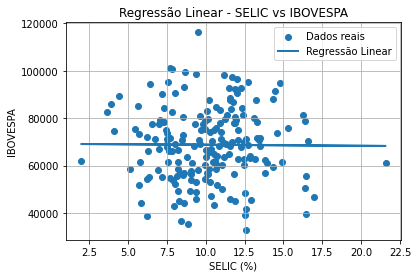

In [0]:
# Importando a biblioteca de plotagem
import matplotlib.pyplot as plt

# Criando o gráfico de dispersão
plt.scatter(X.values, y.values, label="Dados reais")
plt.plot(X.values, model.predict(X), label="Regressão Linear", linewidth=2)

# Adicionando título e legendas
plt.title("Regressão Linear - SELIC vs IBOVESPA")
plt.xlabel("SELIC (%)")
plt.ylabel("IBOVESPA")
plt.legend()
plt.grid(True)
plt.show()


In [0]:
from IPython.display import display, Markdown

display(Markdown("## Conclusão\n\nO pipeline de dados implementado neste projeto permitiu a análise da relação entre o IPCA, a SELIC e o IBOVESPA nos últimos 15 anos. A estrutura em camadas (BRONZE, SILVER e GOLD) garantiu a qualidade e a organização dos dados.\n\nA análise de correlação revelou relações econômicas esperadas, como a correlação negativa entre a taxa SELIC e o índice IBOVESPA. A regressão linear simples confirmou essa tendência, mostrando que o aumento da SELIC tende a impactar negativamente o IBOVESPA.\n\nAs tabelas foram modeladas em estrela para facilitar consultas e análises, e o pipeline está preparado para ser reutilizado com novos dados futuros.")) 


## Conclusão

O pipeline de dados implementado neste projeto permitiu a análise da relação entre o IPCA, a SELIC e o IBOVESPA nos últimos 15 anos. A estrutura em camadas (BRONZE, SILVER e GOLD) garantiu a qualidade e a organização dos dados.

A análise de correlação revelou relações econômicas esperadas, como a correlação negativa entre a taxa SELIC e o índice IBOVESPA. A regressão linear simples confirmou essa tendência, mostrando que o aumento da SELIC tende a impactar negativamente o IBOVESPA.

As tabelas foram modeladas em estrela para facilitar consultas e análises, e o pipeline está preparado para ser reutilizado com novos dados futuros.